## Step1. 데이터 수집하기
- https://github.com/sunnysai12345/News_Summary

```bash
aiffel
└── news_summarization
    ├── project12.ipynb            <─ I am here
    └── data
        └── news_summary_more.csv  <─ 뉴스 기사 데이터
```

## csv파일 읽기

In [1]:
import pandas as pd

news_csv_data = pd.read_csv('data/news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플 수:', (len(news_csv_data)))

전체 샘플 수: 98401


In [2]:
news_csv_data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


`news_summary_more.csv`는 headlines 컬럼과 text 컬럼으로 이루어져 있습니다.  
 추상적 요약을 하는 경우 본문(text 컬럼)과 이미 요약된 데이터(headlines 컬럼)를 모델 학습에 사용합니다.  
 추출적 요약을 하는 경우 text 컬럼만 사용하면 되지만, 추상적 요약을 해야하기에 두 컬럼 모두를 사용합니다.  

## 반복문 진행상황 확인하기
언제 끝날지 알 수 없는 전처리 반복 과정을 `tqdm`라이브러리를 활용하여 진행상황을 보면 덜 답답하지 않을까?

In [3]:
try:
    from tqdm import notebook
except:
    print("tqdm 모듈이 없어 설치합니다.")
    !pip install tqdm
    from tqdm import notebook

## Numpy 라이브러리

In [4]:
import numpy as np

## Step2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리 또는 필요하다고 생각한 전처리를 추가하여 텍스트를 정규화 또는 정제하기

### 중복 샘플과 Null값이 존재하는지 확인하기

#### 중복 샘플 확인하고 제거하기

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', news_csv_data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', news_csv_data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


headlines에서는 98,280개, text에는 98,360개의 유니크한 데이터가 존재합니다.  
text 자체가 중복된 경우는 중복 샘플이므로 제거를 합니다.  

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
news_csv_data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(news_csv_data)))

전체 샘플수 : 98360


#### Null 값을 가진 샘플 확인하고 제거하기

In [7]:
print(news_csv_data.isnull().sum())

headlines    0
text         0
dtype: int64


다행히 Null값이 존재하지 않네요!  
바로 다음 단계로 넘어가겠습니다.  
만약 Null값이 있었다면 아래와 같은 전처리 작업을 진행하면 됩니다.  
```python
news_csv_data.dropna(axis=0, inplace=True)
```

### 텍스트 정규화와 불용어 제거하기

#### 정규화 사전 준비
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어 제거하기

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터 전처리  함수 선언하기
불용어 제거 외에도 텍스트 소문자화, 특숨누자 제거 등 필요한 텍스트 전처리 작업을 진행합니다.

In [10]:
import re
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

##### text 컬럼 전처리

In [17]:
import os
import csv
clean_text_path = 'data/clean_text.csv'
if os.path.isfile(clean_text_path):
    with open(clean_text_path, 'r') as file:
        clean_text = list(csv.reader(file))
        file.close()
else:
    clean_text = []

    for text in notebook.tqdm(news_csv_data['text']):
        _cleaned = preprocess_sentence(text, remove_stopwords=True)
        clean_text.append(_cleaned)
    
    with open(clean_text_path, 'w') as file:
        write = csv.writer(file)
        write.writerow(clean_text)
        file.close()

  0%|          | 0/98360 [00:00<?, ?it/s]

In [18]:
# text컬럼 전처리 전/후 결과 보기
print("Text 전처리 전 결과\n", news_csv_data['text'][0])
print("Text 전처리 후 결과\n", clean_text[0])

Text 전처리 전 결과
 Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Text 전처리 후 결과
 saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers


##### headlines 컬럼 전처리

In [19]:
clean_headlines = []
for text in notebook.tqdm(news_csv_data['headlines']):
    _cleaned = preprocess_sentence(text, remove_stopwords=False)
    clean_headlines.append(_cleaned)

  0%|          | 0/98360 [00:00<?, ?it/s]

In [20]:
# headlines 컬럼 전처리 전/후 결과 보기
print("Text 전처리 전 결과", news_csv_data['headlines'][0])
print("Text 전처리 후 결과", clean_headlines[0])

Text 전처리 전 결과 upGrad learner switches to career in ML & Al with 90% salary hike
Text 전처리 후 결과 upgrad learner switches to career in ml al with salary hike


전처리 작업 후 빈(empty) 데이터가 생겼다면 이를 Null로 대체합니다.

In [21]:
news_csv_data['text'] = clean_text
news_csv_data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
news_csv_data.replace('', np.nan, inplace=True)

##### Null을 가진 데이터가 있는지 확인하기

In [22]:
print(news_csv_data.isnull().sum())

headlines    0
text         0
dtype: int64


이번에도 다행히 Null 데이터는 발견되지 않았습니다! 짝짝!

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


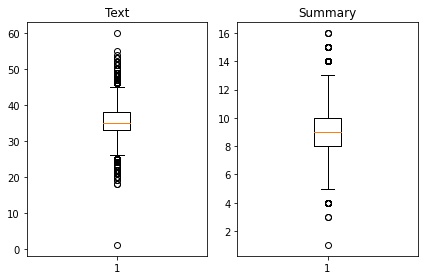

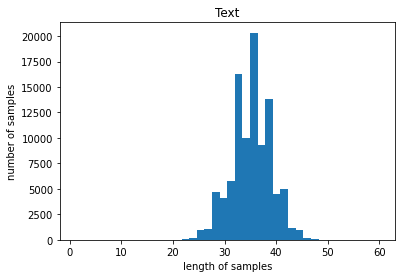

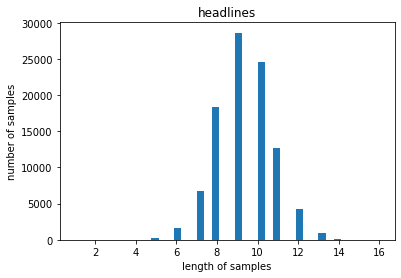

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in news_csv_data['text']]
headlines_len = [len(s.split()) for s in news_csv_data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text의 경우 최소 1에서 최대 60까지 분포되어 있으며 분포도가 고른 편입니다.  
headlines의 경우에도 최소 1에서 최대 16으로 고른 분포도를 갖고 있습니다.

적절한 최대길이는 text의 경우 45 headlines의 경우 12로 정의 해보겠습니다.

In [24]:
text_max_len = 45
headlines_max_len = 12

In [25]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, news_csv_data['text'])
below_threshold_len(headlines_max_len,  news_csv_data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


### 임의로 정한 최대 길이보다 큰 샘플은 제외하기

In [27]:
news_csv_data = news_csv_data[news_csv_data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
news_csv_data = news_csv_data[news_csv_data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

In [28]:
print('전체 샘플수 :', (len(news_csv_data)))

전체 샘플수 : 96871


98,360개의 샘플이 96,871개로 소폭 감소하였습니다.

### 시작 토큰과 종료 토큰 추가하기


In [29]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
news_csv_data['decoder_input'] = news_csv_data['headlines'].apply(lambda x : 'sostoken '+ x)
news_csv_data['decoder_target'] = news_csv_data['headlines'].apply(lambda x : x + ' eostoken')
news_csv_data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장한다.

In [30]:
encoder_input = np.array(news_csv_data['text']) # 인코더의 입력
decoder_input = np.array(news_csv_data['decoder_input']) # 디코더의 입력, 시작 토크
decoder_target = np.array(news_csv_data['decoder_target']) # 디코더의 레이블, 종료 토큰

### 훈련 데이터와 테스트 데이터 분리하기

훈련 데이터와 테스트 데이터를 랜덤으로 섞기 위한 방법

In [31]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[47701 76401   192 ... 42130 83320 83565]


In [32]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [33]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [34]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### 단어 집합 사전 만들기 및 정수 인코딩하기

#### text 데이터

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [36]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69136
등장 빈도가 6번 이하인 희귀 단어의 수: 47109
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22027
단어 집합에서 희귀 단어의 비율: 68.13960888683175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.505495556471073


단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 22,011 이므로 여기서는 20,000 으로 __제한__ 하겠다.

In [37]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[133, 1, 7735, 550, 14657, 1732, 1349, 6586, 111, 1244, 3619, 186, 3254, 3048, 133, 6, 649, 550, 3111, 481, 3381, 5020, 1103, 149, 1444, 652, 7974, 979, 1, 3111, 1219, 6275, 2220], [379, 515, 600, 97, 52, 1, 28, 16, 9583, 3340, 6337, 1330, 37, 186, 4605, 571, 600, 4, 18206, 7846, 600, 3340, 6337, 16571, 8103, 221, 6337, 113, 2110, 234, 8786, 12125, 361, 16572, 8347, 256, 6337, 1368, 16573, 3749], [5156, 36, 11463, 1012, 1810, 464, 527, 610, 2073, 642, 418, 1136, 145, 1, 286, 1774, 482, 24, 784, 5702, 1753, 61, 150, 1, 3855, 47, 2094, 1942, 105, 236, 609, 1753, 150, 4]]


#### headlines 데이터

In [39]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [40]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29980
등장 빈도가 5번 이하인 희귀 단어의 수: 19650
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10330
단어 집합에서 희귀 단어의 비율: 65.54369579719813
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.725121168250771


In [41]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 집합의 크기를 10,000으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 158, 3, 2189, 1078, 9, 176, 3981, 1444, 1540], [1, 518, 827, 489, 403, 151, 4634, 4805, 599, 20], [1, 2250, 3, 8120, 888, 1929, 166, 1040, 2109, 238, 1541], [1, 233, 809, 52, 2051, 4105, 3], [1, 984, 12, 1121, 3289, 2879, 1800, 132]]
target
decoder  [[158, 3, 2189, 1078, 9, 176, 3981, 1444, 1540, 2], [518, 827, 489, 403, 151, 4634, 4805, 599, 20, 2], [2250, 3, 8120, 888, 1929, 166, 1040, 2109, 238, 1541, 2], [233, 809, 52, 2051, 4105, 3, 2], [984, 12, 1121, 3289, 2879, 1800, 132, 2]]


In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19373
테스트 레이블의 개수 : 19373


### 패딩

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step3. 어텐션 메커니즘 사용하기 (추상적요약)
어텐션 메커니즘을 사용한 seq2seq를 사용하기

### 모델 설계하기

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [45]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [46]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

In [47]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

#### 모델 훈련하기

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 69s 100ms/step - loss: 5.6159 - val_loss: 5.1986
Epoch 2/50
303/303 [==============================] - 30s 98ms/step - loss: 5.0441 - val_loss: 4.8264
Epoch 3/50
303/303 [==============================] - 30s 100ms/step - loss: 4.6934 - val_loss: 4.5340
Epoch 4/50
303/303 [==============================] - 31s 102ms/step - loss: 4.4259 - val_loss: 4.3520
Epoch 5/50
303/303 [==============================] - 32s 105ms/step - loss: 4.2213 - val_loss: 4.2218
Epoch 6/50
303/303 [==============================] - 32s 104ms/step - loss: 4.0551 - val_loss: 4.1153
Epoch 7/50
303/303 [==============================] - 31s 104ms/step - loss: 3.9109 - val_loss: 4.0334
Epoch 8/50
303/303 [==============================] - 32s 105ms/step - loss: 3.7840 - val_loss: 3.9640
Epoch 9/50
303/303 [==============================] - 32s 104ms/step - loss: 3.6714 - val_loss: 3.8996
Epoch 10/50
303/303 [==============================] - 32s 104ms/step - lo

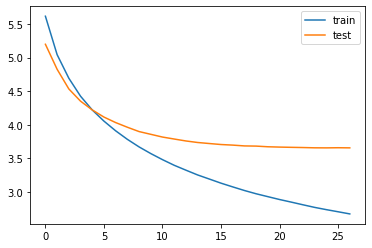

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현
테스트 단계에서 정수 인덱스 행렬로 존재하는 텍스트 데이터를 실제 데이터로 복원하는 과정  
text 단어 집합에서 정수 -> 단어  
headlines 단어 집합에서 단어 -> 정수  
headlines 단어 집합에서 정수 -> 단어  

In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복"

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step4. 실제 결과와 요약문 비교하기 (추상적요약)
headless 컬럼의 내용과 학습을 통해 얻은 추상적 요약 결과를 비교해자

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i !=0 and i!=tar_word_to_index['sostoken']) and i !=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
for i in range(10, 20):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

원문 : english county cricket side surrey scored limited overs format highest team total smashing overs match friends provident trophy april surrey openers put opening stand ali brown going register ball innings saw sixes fours 
실제 요약 : english county team holds highest limited overs score of 
예측 요약 :  england beat nz to take wickets in match against
원문 : union cabinet approved scheduled tribe status six communities assam including communities home minister rajnath singh said bill regard introduced parliament near future added full safeguards provided protect interests rights privileges existing scheduled tribes assam 
실제 요약 : cabinet approves st status for in assam 
예측 요약 :  centre to implement assam assam nrc
원문 : swiss israeli company announced satellite tissue box sized laboratory orbiting earth kilometres completed first phase experiments cells molecules behave differently zero gravity helping researchers make discoveries fields medicine agriculture mini lab facilitates working spac

## Step5. Summa을 이용해서 추출적 요약해보기
Suma의 Summarize을 사용하여 추출적 요약 해보기

전처리까지 모두 완료한 `['text']` 컬럼의 내용이 __충분치 않은지__ Suma의 Summarize 라이브러리가 __작동하지 않았다.__  
그래서 원본 csv파일을 토대로 추출적 요약을 진행해보았다.  
아래 링크는 Github에 올라온 내용이다.  
[why i got empty string #28 - Github](https://github.com/summanlp/textrank/issues/28)

In [56]:
from summa.summarizer import summarize

In [57]:
news_csv_data2 = pd.read_csv('data/news_summary_more.csv', encoding='iso-8859-1')

In [58]:
news_csv_data2.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [59]:
# summarize의 ratio를 조절하면 글자가 보이기도 안보이기도 한다. 이 비율을 잘 조정해야겠다.
# ratio의 범위는 0 ~ 1 사이의 값을 갖는다.
for i in range(10):
    print("실제 요약 : ", news_csv_data2['headlines'][i])
    print("예측 요약 : ", summarize(news_csv_data2['text'][i], ratio=0.5))
    print("\n")


실제 요약 :  upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 :  upGrad's Online Power Learning has powered 3 lakh+ careers.


실제 요약 :  Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 :  Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


실제 요약 :  New Zealand end Rohit Sharma-led India's 12-match winning streak
예측 요약 :  The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


실제 요약 :  Aegon life iTerm insurance plan helps customers save tax
예측 요약 :  Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


실제 요약 :  Have known Hirani for yrs, what if MeToo claims are not true: Sonam
예측 요약 :  Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for ma